In [4]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import timesynth as ts

import matplotlib.pyplot as plt

from robust_pca.utils import drawing, utils
from robust_pca.classes.rpca import RPCA
from robust_pca.classes.improved_rpca import ImprovedRPCA, ImprovedRPCAHyperparams
from robust_pca.classes.noisy_rpca import NoisyRPCA, NoisyRPCAHyperparams

**Generate synthetic data**

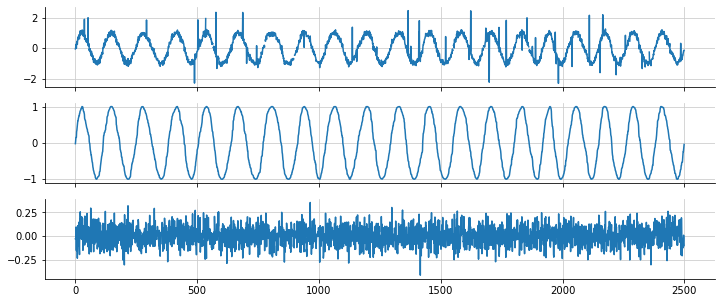

In [5]:
time_sampler = ts.TimeSampler(stop_time=20)
irregular_time_samples = time_sampler.sample_irregular_time(num_points=5_000, keep_percentage=50)
sinusoid = ts.signals.Sinusoidal(frequency=1)
white_noise = ts.noise.GaussianNoise(std=0.1)
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
samples, signals, errors = timeseries.sample(irregular_time_samples)

n = len(samples)
indices = np.random.choice(n, int(n*0.02))
samples[indices] = [np.random.uniform(low=2*np.min(samples), high=2*np.max(samples)) for i in range(int(n*0.02))]
indices = np.random.choice(n, int(n*0.02))
samples[indices] = np.nan

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12,5))
ax[0].plot(range(len(samples)), samples)
ax[1].plot(range(len(signals)), signals)
ax[2].plot(range(len(errors)), errors)
plt.show()

**RPCA**

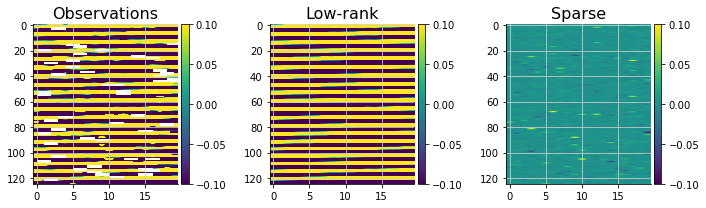

CPU times: user 627 ms, sys: 113 ms, total: 740 ms
Wall time: 674 ms


In [6]:
%%time

rpca = RPCA(signal=samples.tolist(), period=20)
D, X, A = rpca.compute_rpca()
drawing.plot_matrices([D, X, A])
s1, s2, s3 = rpca.resultRPCA_to_signal()
drawing.plot_signal([s1, s2, s3])

**improve PCA**

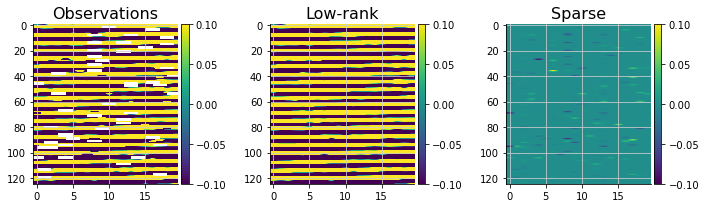

CPU times: user 20.5 s, sys: 7.18 s, total: 27.7 s
Wall time: 3.81 s


In [7]:
%%time

irpca = ImprovedRPCA(signal=samples.tolist(), period=20, lam=0.32)
D, X, A = irpca.compute_improve_rpca()
drawing.plot_matrices([D, X, A])
s1, s2, s3 = irpca.resultRPCA_to_signal()
drawing.plot_signal([s1, s2, s3])

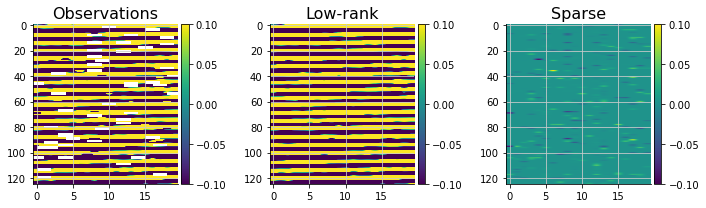

CPU times: user 9min 14s, sys: 2min 41s, total: 11min 55s
Wall time: 1min 46s


In [8]:
%%time

hp = ImprovedRPCAHyperparams(signal=samples.tolist(), period=20)
hp.add_hyperparams(hyperparams_lam=[0.3, 0.35])
D, X, A = hp.compute_improve_rpca_hyperparams()
drawing.plot_matrices([D, X, A])
s1, s2, s3 = hp.resultRPCA_to_signal()
drawing.plot_signal([s1, s2, s3])

**noisy RPCA**

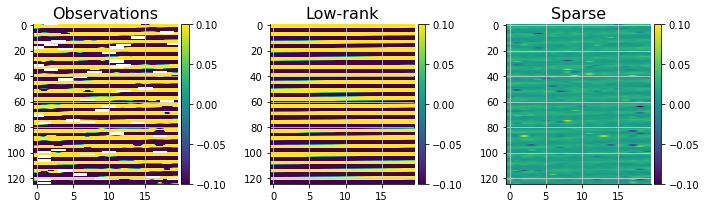

CPU times: user 1min 5s, sys: 18.4 s, total: 1min 23s
Wall time: 11.5 s


In [5]:
%%time

nrpca = NoisyRPCA(signal=samples.tolist(), period=20, tau=3, lam=2.4)
D, X, A = nrpca.compute_noisy_rpca()
drawing.plot_matrices([D, X, A])
s1, s2, s3 = nrpca.resultRPCA_to_signal()
drawing.plot_signal([s1, s2, s3])